# Visualizing the data structure



In [1]:
import numpy as np
from pymob import Config
from pymob.sim.config import Param
from pymob.sim.plot import SimulationPlot

In [4]:
# load case study
from hierarchical_molecular_tktd.sim import (
    NomixHierarchicalSimulation, 
    plot_y0
)

from hierarchical_molecular_tktd.prob import (
    conditional_survival_error_model, 
)

In [5]:
config = Config("../scenarios/hierarchical_cext/settings.cfg")
config.case_study.package = "../.."
config.case_study.data_path = "../../tktd_rna_pulse/data"
sim = NomixHierarchicalSimulation(config)

sim.setup()

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/hierarchical_cext'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext'.


## Implementing the hierarchical error structure for $C_{ext,0}$ ($y_0$)

The stock solutions for each experiment are prepared freshly before the experiment. Exposure solutions are created as direct dilutions from the stock. This means, there is **no** error propagation, through the different dilution steps in different treatments. But, each stock solution can be subject to a preparation error and treatment solutions can also be subject to errors.

Let's unpack the experimental error structure

In [6]:
eid = sim.observations.experiment_id
np.unique(sim.observations.experiment_id)


experiment_index = sim.create_index("experiment_id")

experiment_index["experiment_id"]

substance_index = sim.create_index("substance")

substance_index["substance"].values[experiment_index["experiment_id"] == 27]


array([1])

## Fitting a separate starting value $C_{e,0,i}$ to each ID 

In [7]:

cext_nom = str(sim.model_parameters["y0"]["cext"].values.round(3).tolist()).replace(" ", "")
sim.config.model_parameters.cext_y0 = Param(
    dims=("id",), prior=f"lognorm(scale={cext_nom},s=1)", free=True
)

## Scaling the likelihood functions w.r.t the number of observations

In [8]:
sim.observations.count()

# TODO: Pass numbers to inferer as extra variables


<xarray.Dataset>
Dimensions:    ()
Data variables:
    lethality  int64 392
    nrf2       int64 169
    cext       int64 499
    cint       int64 913
    survival   int64 392

In [9]:
sim.dispatch_constructor()
e = sim.dispatch({})
e()
e.results


<xarray.Dataset>
Dimensions:              (id: 314, time: 23)
Coordinates:
  * id                   (id) object '101_0' '101_1' '106_0' ... '77_7' '77_8'
  * time                 (time) float64 24.0 25.5 27.0 ... 114.0 117.0 120.0
    hpf                  (id) float64 24.0 24.0 24.0 24.0 ... 24.0 24.0 24.0
    nzfe                 (id) float64 nan nan nan nan ... 18.0 18.0 18.0 18.0
    treatment_id         (id) int64 101 101 106 106 112 112 ... 77 77 77 77 77
    experiment_id        (id) int64 36 36 36 36 36 36 36 ... 31 31 31 31 31 31
    substance            (id) <U10 'diuron' 'diuron' ... 'naproxen' 'naproxen'
    substance_index      (id) int64 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2
    experiment_id_index  (id) int64 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11
Data variables:
    cext                 (id, time) float32 2.34 2.34 2.34 ... 309.2 309.2 309.2
    cint                 (id, time) float32 0.0 1.755 ... 1.438e+04 1.484e+04
    nrf2                 (id, time) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    P                    (id, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    H                    (id, time) float32 0.0 1.5e-07 ... 9.3e-06 9.6e-06
    survival             (id, time) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [10]:
sim.dispatch_constructor()
sim.set_inferer("numpyro")
sim.use_numpyro_backend(
    error_model=conditional_survival_error_model,
    only_prior=False
)
sim.inferer.prior

Jax 64 bit mode: False
Absolute tolerance: 1e-06
Jax 64 bit mode: False
Absolute tolerance: 1e-06


{'k_i_substance': LogNormalTrans(loc=[1.0, 1.0, 1.0], scale=2, dims=('substance=3',), obs=None),
 'r_rt_substance': LogNormalTrans(loc=[1.0, 1.0, 1.0], scale=2, dims=('substance=3',), obs=None),
 'r_rd_substance': LogNormalTrans(loc=[0.5, 0.5, 0.5], scale=2, dims=('substance=3',), obs=None),
 'v_rt_substance': LogNormalTrans(loc=[10.0, 10.0, 10.0], scale=2, dims=('substance=3',), obs=None),
 'z_ci_substance': LogNormalTrans(loc=[0.5, 0.5, 0.5], scale=2, dims=('substance=3',), obs=None),
 'k_p_substance': LogNormalTrans(loc=[0.02, 0.02, 0.02], scale=2, dims=('substance=3',), obs=None),
 'k_m_substance': LogNormalTrans(loc=[0.05, 0.05, 0.05], scale=2, dims=('substance=3',), obs=None),
 'h_b_substance': LogNormalTrans(loc=[1e-08, 1e-07, 1e-07], scale=2, dims=('substance=3',), obs=None),
 'z_substance': LogNormalTrans(loc=[1.0, 1.0, 1.0], scale=2, dims=('substance=3',), obs=None),
 'kk_substance': LogNormalTrans(loc=[0.02, 0.02, 0.02], scale=2, dims=('substance=3',), obs=None),
 'sigma_nrf

'../../hierarchical_molecular_tktd/results/hierarchical_cext/y0_nominal_prior.png'

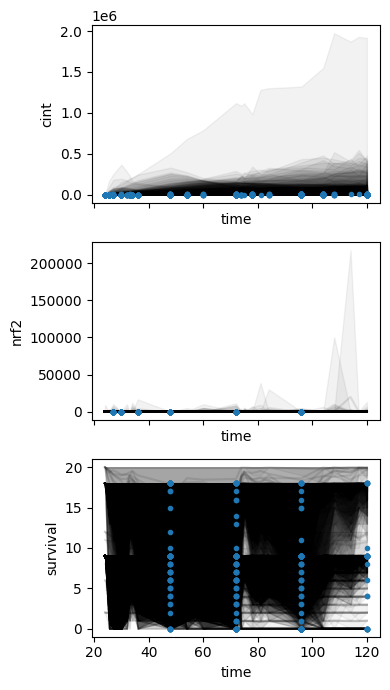

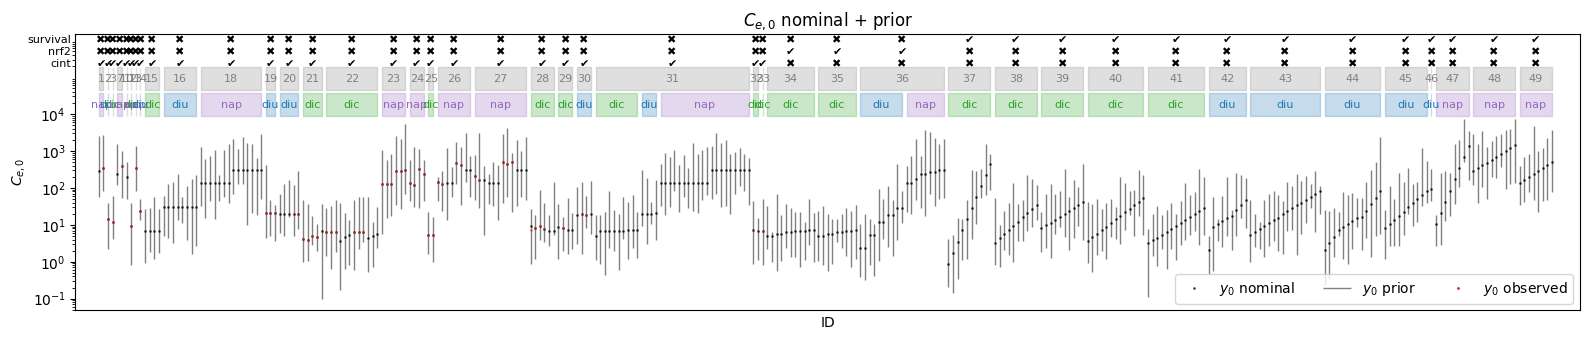

In [14]:
idata = sim.inferer.prior_predictions(n=11)

checks = {}
flag = sim.inferer.check_prior_for_nans(idata=idata)
checks.update({"NaN values in prior draws": flag})

if not all(checks.values()):
    raise ValueError("Not all checks passed.")

simplot = SimulationPlot(
    observations=sim.observations,
    idata=idata,
    coordinates=sim.dimension_coords,
    config=sim.config,
    idata_groups=["prior_predictive"],
)   
simplot.plot_data_variables()
plot_y0(
    sim=sim, idata=idata, parameter="cext", idata_group="prior", 
    levels=["experiment_id", "substance",], 
    colors={"substance": ["tab:green", "tab:blue", "tab:purple"]},
    show_observed=True,
    show_measured_endpoints=True,
)

In [15]:
idata.log_likelihood.mean(("chain", "draw")).sum()

<xarray.Dataset>
Dimensions:   ()
Data variables:
    cint      float32 -2.489e+07
    nrf2      float32 -1.122e+03
    survival  float32 -6.131e+03

                  Trace Shapes:          
                   Param Sites:          
                  Sample Sites:          
 k_i_substance_normal_base dist       3 |
                          value       3 |
r_rt_substance_normal_base dist       3 |
                          value       3 |
r_rd_substance_normal_base dist       3 |
                          value       3 |
v_rt_substance_normal_base dist       3 |
                          value       3 |
z_ci_substance_normal_base dist       3 |
                          value       3 |
 k_p_substance_normal_base dist       3 |
                          value       3 |
 k_m_substance_normal_base dist       3 |
                          value       3 |
 h_b_substance_normal_base dist       3 |
                          value       3 |
   z_substance_normal_base dist       3 |
                          value       3 |
  kk_substance_normal_base dist       3 |
                          value       3 |
    sigma_nrf2_normal_base dist   

100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s, init loss: 710947.6875, avg. loss [951-1000]: 1527.3773]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
cext_y0[101_0]               1.759  1.462   0.165    4.235      0.033   
cext_y0[101_1]               2.706  3.172   0.157    7.249      0.075   
cext_y0[106_0]               2.472  2.404   0.091    6.104      0.057   
cext_y0[106_1]               3.647  2.832   0.348    8.618      0.064   
cext_y0[112_0]              12.673  5.730   4.501   23.130      0.132   
...                            ...    ...     ...      ...        ...   
z_ci_substance[diclofenac]   0.412  0.030   0.360    0.469      0.001   
z_ci_substance[naproxen]     0.241  0.021   0.201    0.278      0.000   
z_substance[diuron]          1.714  0.116   1.482    1.928      0.003   
z_substance[diclofenac]      1.836  0.148   1.555    2.104      0.003   
z_substance[naproxen]        2.348  0.161   2.035    2.639      0.004   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
cext_y0[101_0]                0.023    1960.0    1987.0   

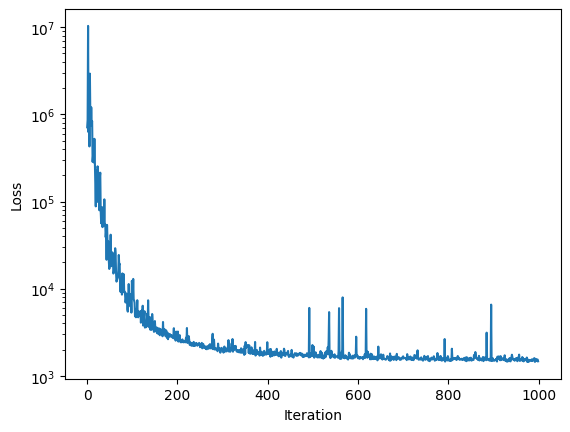

In [16]:
sim.config.inference.n_predictions = 100
sim.config.inference_numpyro.kernel = "svi"
sim.config.inference_numpyro.init_strategy = "init_to_uniform"
sim.config.inference_numpyro.svi_iterations = 1000
sim.config.inference_numpyro.svi_learning_rate = 0.01
sim.config.simulation.seed=4
sim.dispatch_constructor()

if True:
    sim.inferer.run()
    sim.inferer.store_results(output="numpyro_svi_posterior.nc")
    idata = sim.inferer.idata
else:
    idata = sim.inferer.load_results(file="numpyro_svi_posterior")

'../../hierarchical_molecular_tktd/results/hierarchical_cext/y0_nominal_posterior.png'

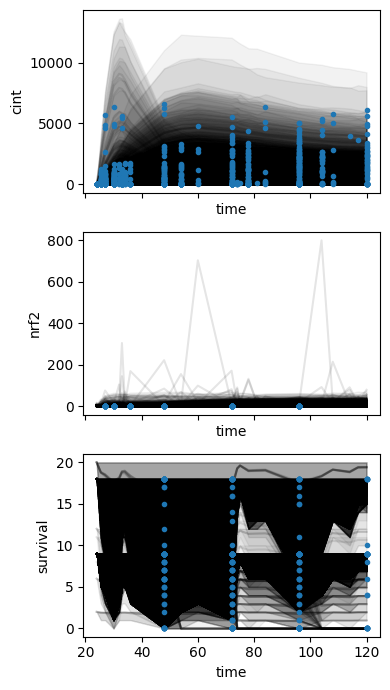

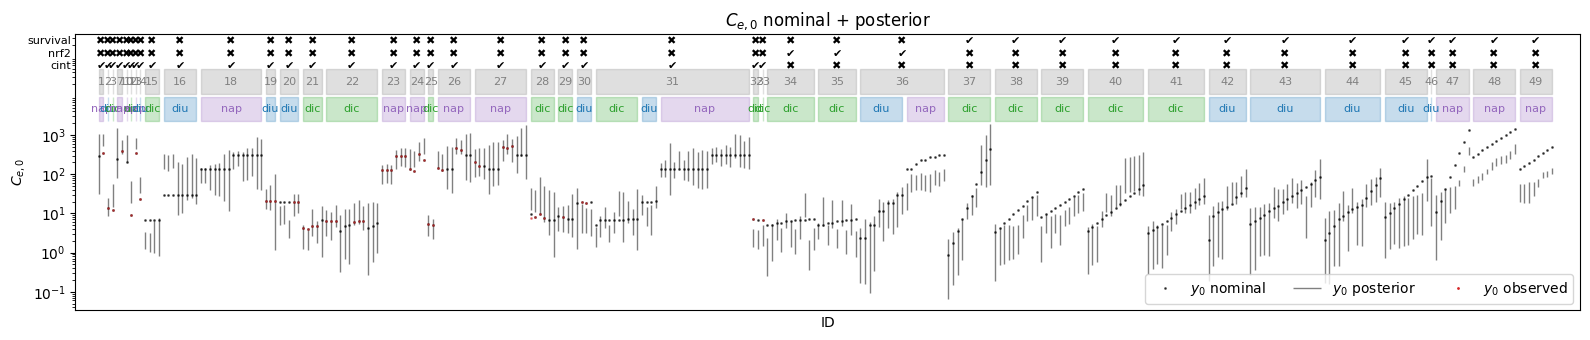

In [19]:
simplot = SimulationPlot(
    observations=sim.observations,
    idata=sim.inferer.idata,
    coordinates=sim.dimension_coords,
    config=sim.config,
    idata_groups=["posterior_predictive"],
)   
simplot.plot_data_variables()
plot_y0(
    sim=sim, idata=idata, parameter="cext", idata_group="posterior", 
    levels=["experiment_id", "substance",], 
    colors={"substance": ["tab:green", "tab:blue", "tab:purple"]},
    show_observed=True,
    show_measured_endpoints=True,
)

In [20]:
sim.seed=2
sim.config.inference.n_predictions = 1
sim.coordinates["time"] = np.linspace(24,120,200)
sim.dispatch_constructor()
sim._plot.pretty_posterior_plot_multisubstance(sim)
sim.reset_coordinate("time")

PRETTY PLOT: starting...


Posterior predictions: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


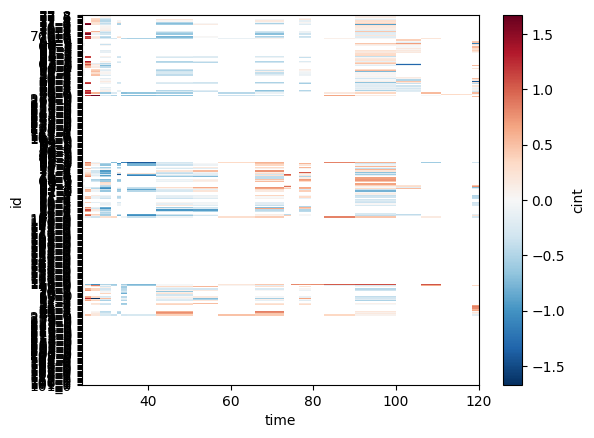

In [21]:
idata.posterior_residuals.cint.mean(("chain","draw")).plot()

In [22]:
sim.dispatch_constructor()
loglik, _ = sim.inferer.create_log_likelihood(return_type="summed-by-prior-data", scaled=False, gradients=False, vectorize=False)

In [23]:
posterior_mean = idata.unconstrained_posterior.mean(("chain", "draw"))
theta = {k: np.array(v.to_dict()["data"]) for k, v in posterior_mean.data_vars.items()}
loglik(theta=theta)

(Array(-1288.7, dtype=float32),
 Array(-446.73926, dtype=float32),
 Array(-954.0963, dtype=float32))

In [24]:
sim.config.case_study.scenario = "hierarchical_cext_nested"
sim.config.create_directory("scenario", force=True)
sim.config.save(force=True)

Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested'.


In [25]:
idata.log_likelihood.sum().to_array() / np.array([913,169,392])

<xarray.DataArray (variable: 3)>
array([-1411.50328587,  -423.71015163, -2192.82126913])
Coordinates:
  * variable  (variable) object 'cint' 'nrf2' 'survival'